# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-17 20:04:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [  <=>               ] 201.24M  25.4MB/s    in 8.8s    

2023-10-17 20:04:28 (22.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge(random_state=set_random_seed(42))
model.fit(X_train_scaled, y_train)
pred = model.predict(X_test_scaled)
rmse_for_model = mean_squared_error(y_test, pred, squared=False)

In [ ]:
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
pred_mean = np.array([y_train.mean()] * y_test.shape[0])
best_rmse_metric = mean_squared_error(y_test, pred_mean, squared=False)

In [ ]:
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!

In [ ]:
from torch.utils.data import Dataset

In [ ]:
# создаю линейную модель
lin_model = nn.Linear(X_train.shape[1], 1)

In [ ]:
lin_model.to(device)

Linear(in_features=90, out_features=1, bias=True)

In [ ]:
# создаю класс для сетов, чтобы поместить в даталоадер
class SongsDataset(Dataset):

  def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
    self.X = X
    self.y = y

  def __len__(self) -> int:
    return len(self.X)

  def __getitem__(self, index: int) -> tuple:
    return torch.tensor(self.X[index, :], dtype=torch.float), self.y[index]

In [ ]:
train_set = SongsDataset(X_train_scaled, y_train)
test_set = SongsDataset(X_test_scaled, y_test)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=100)

In [ ]:
def rmse(*args) -> torch.Tensor:
  return torch.sqrt(torch.square(args[0] - args[1]).mean())

In [ ]:
num_epoch = 10
learning_rate = 0.05

# обучение модели
train_loss_list = []
test_loss_list = []
epochs = []
# w = torch.randn(train_loader.dataset.)
for epoch in tqdm(range(num_epoch)):
  train_loss = 0.0
  epochs.append(epoch)
  for x_train, y_t in train_loader:
    y_pred = lin_model(x_train.to(device))
    rmse_score = rmse(y_pred, y_t.to(device))
    train_loss += rmse_score.item()
    rmse_score.backward()

    lin_model.weight.data -= learning_rate * lin_model.weight.grad
    lin_model.bias.data -= learning_rate * lin_model.bias.grad
    lin_model.weight.grad.data.zero_()
    lin_model.bias.grad.data.zero_()

  train_loss_avg = train_loss / len(train_loader.dataset)
  train_loss_list.append(train_loss_avg)
  print(f'train: epoch: {epoch} -- RMSE loss: {train_loss_avg}')

  test_loss = 0.0
  for x_test, y_te in test_loader:
    with torch.no_grad():
      y_test_pred = lin_model(x_test.to(device))
      rmse_score_test = rmse(y_test_pred, y_te.to(device))
    test_loss += rmse_score_test.item()
  test_loss_avg = test_loss / len(test_loader.dataset)
  test_loss_list.append(test_loss_avg)
  print(f'test: epoch: {epoch} -- RMSE loss: {test_loss_avg}')


  0%|          | 0/10 [00:00<?, ?it/s]

train: epoch: 0 -- RMSE loss: 18.828376158980245
test: epoch: 0 -- RMSE loss: 17.68996082212074
train: epoch: 1 -- RMSE loss: 16.50916725631626
test: epoch: 1 -- RMSE loss: 15.368136974381265
train: epoch: 2 -- RMSE loss: 14.190371171986195
test: epoch: 2 -- RMSE loss: 13.046994668154113
train: epoch: 3 -- RMSE loss: 11.871585400513297
test: epoch: 3 -- RMSE loss: 10.725327696016125
train: epoch: 4 -- RMSE loss: 9.55234122627727
test: epoch: 4 -- RMSE loss: 8.402659671657103
train: epoch: 5 -- RMSE loss: 7.2311276588091555
test: epoch: 5 -- RMSE loss: 6.078329062882076
train: epoch: 6 -- RMSE loss: 4.910771775233584
test: epoch: 6 -- RMSE loss: 3.757119132113415
train: epoch: 7 -- RMSE loss: 2.5951493411741127
test: epoch: 7 -- RMSE loss: 1.441250773785813
train: epoch: 8 -- RMSE loss: 0.5001296649258833
test: epoch: 8 -- RMSE loss: 0.10799313769099464
train: epoch: 9 -- RMSE loss: 0.10867126621720877
test: epoch: 9 -- RMSE loss: 0.1078015776491433


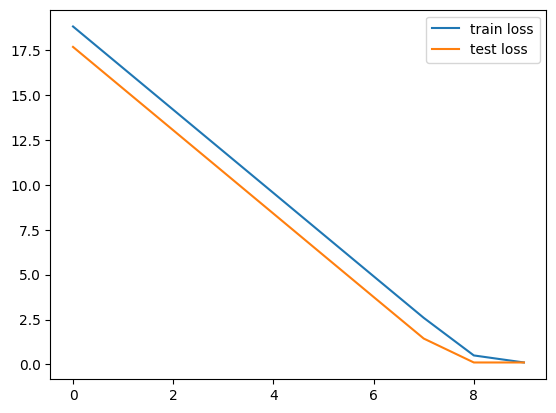

In [ ]:
# рисование графика функции потерь
plt.plot(epochs, train_loss_list, label='train loss')
plt.plot(epochs, test_loss_list, label='test loss')
plt.legend()
plt.show()

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
y_train_res = y_train.reshape(-1, 1)
y_test_res = y_test.reshape(-1, 1)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train_res)
y_test_scaled = y_scaler.transform(y_test_res)

In [ ]:
# параметры лучшей попытки

train_set = SongsDataset(X_train_scaled, y_train_scaled)
test_set = SongsDataset(X_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=64)

num_hidden = 1024

model = nn.Sequential(
    nn.Linear(X_train.shape[1], num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden // 2),
    nn.BatchNorm1d(num_hidden // 2),
    nn.ReLU(),
    nn.Linear(num_hidden // 2, num_hidden // 4),
    nn.BatchNorm1d(num_hidden // 4),
    nn.ReLU(),
    nn.Linear(num_hidden // 4, num_hidden // 8),
    nn.BatchNorm1d(num_hidden // 8),
    nn.ReLU(),
    nn.Linear(num_hidden // 8, 1),
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, gamma=0.1, milestones=[6,7,8])
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
num_epochs = 10

In [ ]:
def train(model, optimizer, criterion, train_loader, train_loss_list):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """

    train_loss = 0.0
    for x_train, y_train in tqdm(train_loader, desc='Train'):
      optimizer.zero_grad()
      y_pred = model(x_train.to(device))
      mse_score = criterion(y_pred, y_train.float().to(device))
      train_loss += mse_score.item()
      mse_score.backward()
      optimizer.step()

    train_loss_avg = train_loss / len(train_loader.dataset)
    train_loss_list.append(train_loss_avg)
    print(f'train: epoch: {epoch+1} -- MSE loss: {train_loss_avg}')

    clear_output(True)
    plt.figure(figsize=(6, 6))
    plt.plot(list(range(1, epoch+2)), train_loss_list)
    plt.show()

def test(model, criterion, test_loader, test_loss_list):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    test_loss = 0.0
    for x_test, y_test in tqdm(test_loader, desc='Test'):
      with torch.no_grad():
        y_test_pred = model(x_test.to(device))
        mse_score_test = criterion(y_test_pred, y_test.float().to(device))
      test_loss += mse_score_test.item()

    test_loss_avg = test_loss / len(test_loader.dataset)
    test_loss_list.append(test_loss_avg)
    print(f'test: epoch: {epoch+1} -- MSE loss: {test_loss_avg}')

    if len(test_loss_list) > 1:
      plt.plot(list(range(1, epoch+2)), test_loss_list)
      plt.show()

    return model(torch.from_numpy(test_loader.dataset.X).to(torch.float32).to(device))


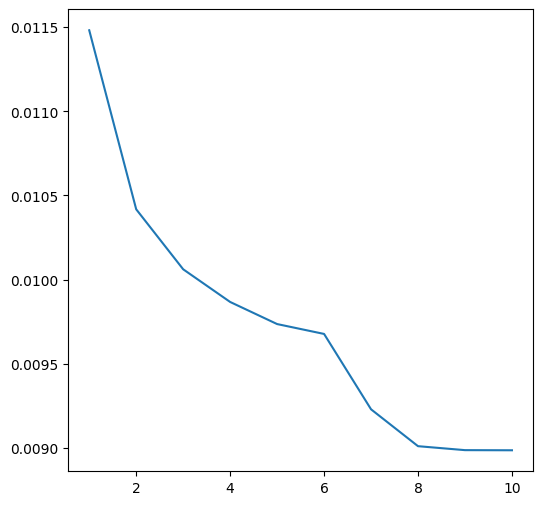

Test:   0%|          | 0/807 [00:00<?, ?it/s]

test: epoch: 10 -- MSE loss: 0.009986598571788057


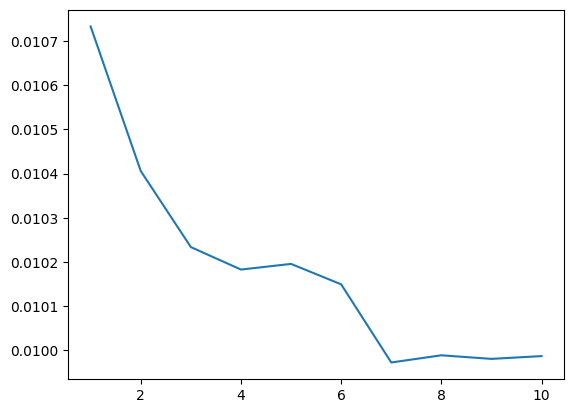

In [ ]:
for epoch in range(num_epochs):
  model.train()
  train(model, optimizer, criterion, train_loader, train_loss_list)

  model.eval()
  prediction = test(model, criterion, test_loader, test_loss_list)

  scheduler.step()

In [ ]:
set_random_seed(42)

In [ ]:
# анскейлю предикт и целевую переменную
y_test_unscaled = y_scaler.inverse_transform(test_loader.dataset.y)
y_test_torch_unscaled  = torch.from_numpy(y_test_unscaled).to(torch.float32)

if device == 'cuda' and isinstance(prediction, torch.Tensor):
  prediction = prediction.cpu()
if isinstance(prediction, torch.Tensor):
  prediction = prediction.detach().numpy()
pred_unscaled = y_scaler.inverse_transform(prediction)
pred_torch_unscaled = torch.from_numpy(pred_unscaled).to(torch.float32)

In [ ]:
print(f'Final RMSE score: {rmse(pred_torch_unscaled.to(device).unsqueeze(1), y_test_torch_unscaled.unsqueeze(1).to(device))}')

Final RMSE score: 8.745043754577637


In [ ]:
test_loss_list = []
assert test(model, criterion, test_loader, test_loss_list).shape[0] == y_test.shape[0]

Test:   0%|          | 0/807 [00:00<?, ?it/s]

test: epoch: 10 -- MSE loss: 0.009991127167726103


In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

*Чтобы достичь результата, я пробовал разные learning rate градиентного спуска и щедулеры (а именно пробовал ExponentialLR, LinearLR и MultiStepLR), коэффициенты регуляризации, разное количество линейных слоёв и нейронов, также добавил батчнормы и нормализовал таргет.*

1. Сначала неплохой результат выдавался уже на линейной модели из 4 слоёв без батчнорма и с маленьким количеством нейронов в слоях со следующими параметрами:

In [35]:
train_set = SongsDataset(X_train_scaled, y_train_scaled)
test_set = SongsDataset(X_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=64)

num_hidden = 10

model = nn.Sequential(
    nn.Linear(X_train.shape[1], num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden // 2),
    nn.ReLU(),
    nn.Linear(num_hidden // 2, num_hidden // 4),
    nn.ReLU(),
    nn.Linear(num_hidden // 4, num_hidden // 1)
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
num_epochs = 10

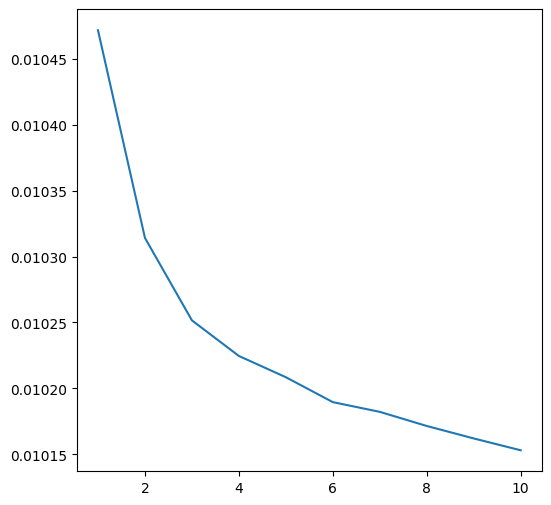

Test:   0%|          | 0/807 [00:00<?, ?it/s]

test: epoch: 10 -- MSE loss: 0.010573242202981276


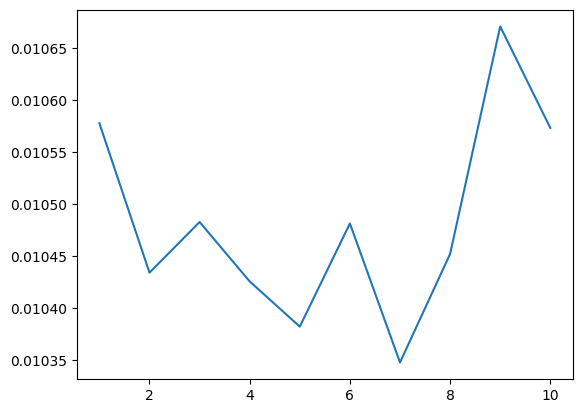

In [37]:
for epoch in range(num_epochs):
  model.train()
  train(model, optimizer, criterion, train_loader, train_loss_list)

  model.eval()
  prediction = test(model, criterion, test_loader, test_loss_list)

In [38]:
y_test_unscaled = y_scaler.inverse_transform(test_loader.dataset.y)
y_test_torch_unscaled  = torch.from_numpy(y_test_unscaled).to(torch.float32)

if device == 'cuda' and isinstance(prediction, torch.Tensor):
  prediction = prediction.cpu()
if isinstance(prediction, torch.Tensor):
  prediction = prediction.detach().numpy()
pred_unscaled = y_scaler.inverse_transform(prediction)
pred_torch_unscaled = torch.from_numpy(pred_unscaled).to(torch.float32)

In [39]:
print(f'Final RMSE score: {rmse(pred_torch_unscaled.to(device).unsqueeze(1), y_test_torch_unscaled.unsqueeze(1).to(device))}')

Final RMSE score: 8.997376441955566


Заметно, что график лоссов очень нестабильный, и действительно модель с этими параметрами при нескольких запусках давала разные результаты в диапазоне примерно [8.83, 9.00].

2. Затем я, например, добавил батчнормы и поработал с lr SGD, а также увеличил количество нейронов

In [44]:
train_set = SongsDataset(X_train_scaled, y_train_scaled)
test_set = SongsDataset(X_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=64)

num_hidden = 128

model = nn.Sequential(
    nn.Linear(X_train.shape[1], num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden // 2),
    nn.BatchNorm1d(num_hidden // 2),
    nn.ReLU(),
    nn.Linear(num_hidden // 2, num_hidden // 4),
    nn.BatchNorm1d(num_hidden // 4),
    nn.ReLU(),
    nn.Linear(num_hidden // 4, num_hidden // 1)
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
num_epochs = 10

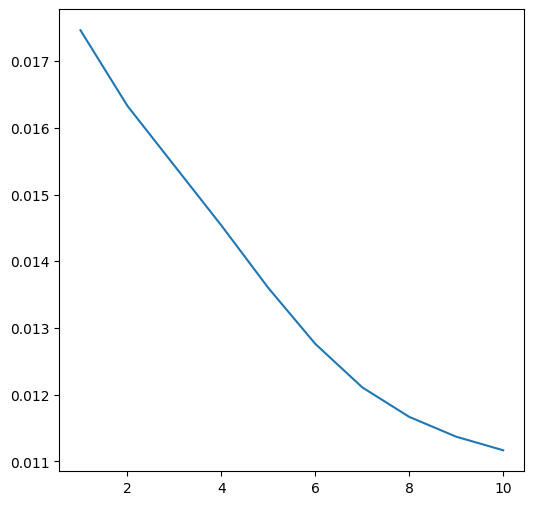

Test:   0%|          | 0/807 [00:00<?, ?it/s]

test: epoch: 10 -- MSE loss: 0.011080139002642058


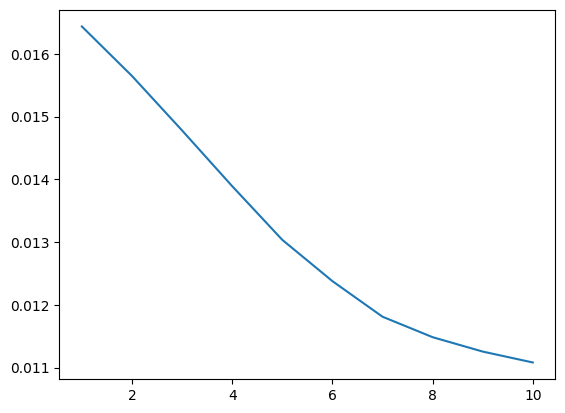

In [45]:
for epoch in range(num_epochs):
  model.train()
  train(model, optimizer, criterion, train_loader, train_loss_list)

  model.eval()
  prediction = test(model, criterion, test_loader, test_loss_list)

In [46]:
y_test_unscaled = y_scaler.inverse_transform(test_loader.dataset.y)
y_test_torch_unscaled  = torch.from_numpy(y_test_unscaled).to(torch.float32)

if device == 'cuda' and isinstance(prediction, torch.Tensor):
  prediction = prediction.cpu()
if isinstance(prediction, torch.Tensor):
  prediction = prediction.detach().numpy()
pred_unscaled = y_scaler.inverse_transform(prediction)
pred_torch_unscaled = torch.from_numpy(pred_unscaled).to(torch.float32)

In [47]:
print(f'Final RMSE score: {rmse(pred_torch_unscaled.to(device).unsqueeze(1), y_test_torch_unscaled.unsqueeze(1).to(device))}')

Final RMSE score: 9.210488319396973


Эта модель постепенно снижает ошибку, однако очень медленно.

3. Наконец, я стал экспериментировать с щедулером

In [52]:
train_set = SongsDataset(X_train_scaled, y_train_scaled)
test_set = SongsDataset(X_test_scaled, y_test_scaled)

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=64)

num_hidden = 1024

model = nn.Sequential(
    nn.Linear(X_train.shape[1], num_hidden),
    nn.BatchNorm1d(num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_hidden // 2),
    nn.BatchNorm1d(num_hidden // 2),
    nn.ReLU(),
    nn.Linear(num_hidden // 2, num_hidden // 4),
    nn.BatchNorm1d(num_hidden // 4),
    nn.ReLU(),
    nn.Linear(num_hidden // 4, num_hidden // 8),
    nn.BatchNorm1d(num_hidden // 8),
    nn.ReLU(),
    nn.Linear(num_hidden // 8, 1),
).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
criterion = nn.MSELoss()

train_loss_list = []
test_loss_list = []
num_epochs = 10

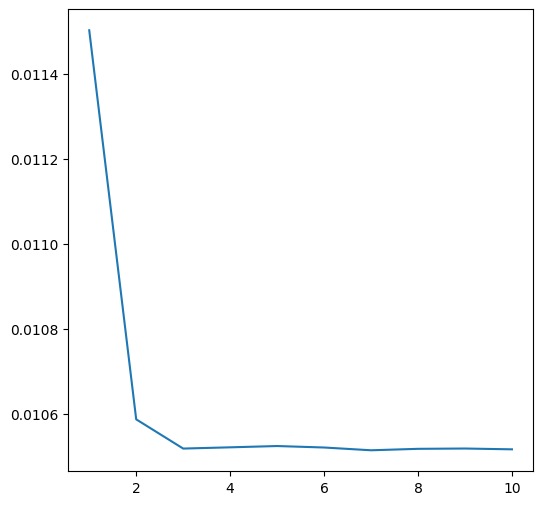

Test:   0%|          | 0/807 [00:00<?, ?it/s]

test: epoch: 10 -- MSE loss: 0.010665139910926796


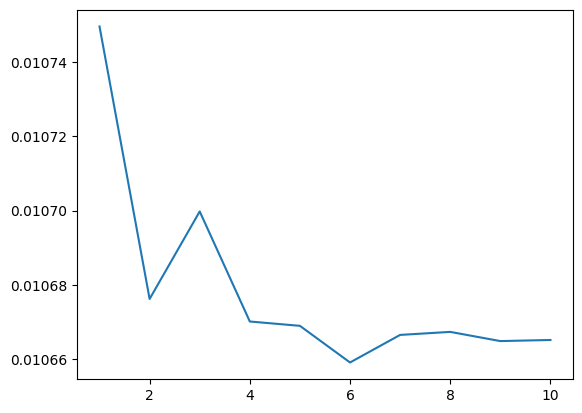

In [53]:
for epoch in range(num_epochs):
  model.train()
  train(model, optimizer, criterion, train_loader, train_loss_list)

  model.eval()
  prediction = test(model, criterion, test_loader, test_loss_list)

  scheduler.step()

In [54]:
y_test_unscaled = y_scaler.inverse_transform(test_loader.dataset.y)
y_test_torch_unscaled  = torch.from_numpy(y_test_unscaled).to(torch.float32)

if device == 'cuda' and isinstance(prediction, torch.Tensor):
  prediction = prediction.cpu()
if isinstance(prediction, torch.Tensor):
  prediction = prediction.detach().numpy()
pred_unscaled = y_scaler.inverse_transform(prediction)
pred_torch_unscaled = torch.from_numpy(pred_unscaled).to(torch.float32)

In [55]:
print(f'Final RMSE score: {rmse(pred_torch_unscaled.to(device).unsqueeze(1), y_test_torch_unscaled.unsqueeze(1).to(device))}')

Final RMSE score: 9.037140846252441


Видно, что, кажется, такой щедулер слишком быстро приводит к переобучению (на трейне всё очень красиво, а вот график теста немного шатает), но при этом само по себе наличие изменения learning rate'а должно помочь.

*В конечном итоге я остановился на щедулере с несколькими линейными изменениями lr на последних эпохах. Также во время подбора моделей я менял гиперпараметры SGD, продолжал экспериментировать с количеством слоёв. Только ближе в концу обучения я решил сильно увеличить количество нейронов на слоях (до этого ставил не больше 128, а в итоге увеличил до 1024), и, кажется, это и дало конечный результат (см. задание 2)*